This notebook reproduces logit matching attack where the goal of an adversary is to reduce the difference between the logits of benign and adversarial images in addition to change in label. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os
import torch.optim as optim

In [4]:
#from rev2.cifar10.model_utils import resnet50, CIFAR10_RESNET50_CKPT_PATH

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, out_keys=None):
        out = {}
        x = self.conv1(x)
        out["c1"] = x
        x = self.bn1(x)
        out["bn1"] = x
        x = F.relu(x)
        out["r1"] = x

        x = self.layer1(x)
        out["l1"] = x
        x = self.layer2(x)
        out["l2"] = x
        x = self.layer3(x)
        out["l3"] = x
        x = self.layer4(x)
        out["l4"] = x

        x = F.avg_pool2d(x, 4)
        out["gvp"] = x
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        out["fc"] = x

        if out_keys is None:
            return x
        res = {}
        for key in out_keys:
            res[key] = out[key]
        return res


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])


def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])


def resnet50():
    return ResNet(Bottleneck, [3,4,6,3])


def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])


def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])


def test():
    net = ResNet18()
    y = net(torch.randn(1,3,32,32))
    print(y.size())

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
def load_cifar_model(path):
    model = resnet50()
    ckpt_dict = torch.load(path, lambda storage, loc: storage)
    model.load_state_dict(ckpt_dict)
    model.to('cuda')
    model.train(False)
    return model

modelpath = "/data/virtual environments/adv detection by robustness/adv_detection/Adaptive attacks/Models/CIFAR10/resnet50/cifar.ckpt"

normal_model = load_cifar_model(modelpath)
normal_model.to(device)
normal_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

In [16]:
def pgd_attack(model, images, labels, eps=16/255, alpha=8/255, iters=40):

    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)

    loss = nn.CrossEntropyLoss()
    adv_images = images.clone().detach()

    for i in range(iters):
        adv_images.requires_grad = True
        outputs = model(adv_images)

        #calculate loss
        cost = loss(outputs, labels)

        #update adversarial images
        grad = torch.autograd.grad(cost, adv_images, retain_graph=False, create_graph=False)[0]
        adv_images = adv_images.detach() + alpha*grad.sign()
        delta = torch.clamp(adv_images - images, min=-eps, max=eps)
        adv_images = torch.clamp(images + delta, min=0, max=1).detach()


    return adv_images

In [17]:
import torch
import torch.nn.functional as F

def pgd_logit_attack(images, labels, target_model, epsilon=16/255, alpha=8/255, num_iterations=100):

    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)

    loss = nn.CrossEntropyLoss()
    adv_images = images.clone().detach()

    clean_logits = target_model(images)

    for i in range(num_iterations):
        adv_images.requires_grad= True
        outputs = target_model(adv_images)
        
        pgd_loss = loss(outputs, labels)
        adv_logits = target_model(adv_images)
        logit_loss = F.mse_loss(clean_logits, adv_logits)
        total_loss = pgd_loss + logit_loss
        
        #update adv images
        grad = torch.autograd.grad(total_loss, adv_images, retain_graph=True)[0]
        adv_images = adv_images.detach() + alpha*grad.sign()
        delta = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
        adv_images = torch.clamp(images+delta, min=0, max=1).detach()

    return adv_images

In [18]:
# Example usage:
#save image as np arrays
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=torchvision.transforms.ToTensor())
test_loader_cifar = DataLoader(testset, shuffle=True, batch_size=10)

Files already downloaded and verified


In [20]:
adversarial_images = []
adversarial_labels = []
benign_images = []
benign_labels = []

for step, (images, labels) in enumerate(test_loader_cifar):
    images = images.to(device)
    labels = labels.to(device)
    adversarial_batch = pgd_logit_attack(images, labels, normal_model)
    _, y_pred = normal_model(adversarial_batch).max(1)
    index = (y_pred != labels)
    adv_images = adversarial_batch[index]
    y_pred_adv = y_pred[index]
    b_images = images[index]
    b_labels = labels[index]
    benign_images.append(b_images.detach().cpu().numpy())
    benign_labels.append(b_labels.detach().cpu().numpy())

    adversarial_images.append(adv_images.detach().cpu().numpy())
    adversarial_labels.append(y_pred_adv.detach().cpu().numpy())
    if step%20==0:
        print(step)
    if step==100:
        break

adv_images = np.concatenate(adversarial_images)
adv_labels = np.concatenate(adversarial_labels)

ben_images = np.concatenate(benign_images)
ben_labels = np.concatenate(benign_labels)

0
20
40
60
80
100


In [22]:
save_dir = 'adaptive samples/'
np.savez(os.path.join(save_dir,'pgd_logit_attack_16255.npz'), a_images=adv_images, a_labels=adv_labels, b_images=ben_images, b_labels=ben_labels)

# Evaluate various measures on the logit matching attack

In [23]:
npobj = np.load('adaptive samples/pgd_logit_attack_16255.npz')

In [24]:
keys = npobj.files
print(keys)

['a_images', 'a_labels', 'b_images', 'b_labels']


In [28]:
adaptive_image = npobj['a_images']
adaptive_label = npobj['a_labels']
ben_image = npobj['b_images']
ben_label = npobj['b_labels']

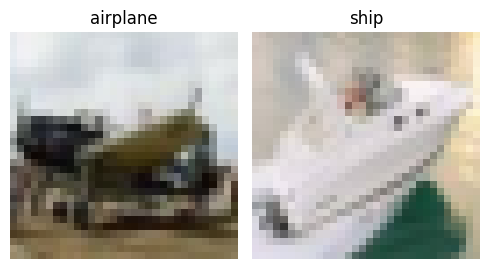

In [29]:
# Define the class names for CIFAR
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))

for i, ax in enumerate(axes.flatten()):
    # Access the image and label at the current index
    image = np.transpose(ben_image[i], (1, 2, 0))  # Transpose to (height, width, channels)
    label = ben_label[i]

    # Plot the image
    ax.imshow(image)
    ax.set_title(class_names[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

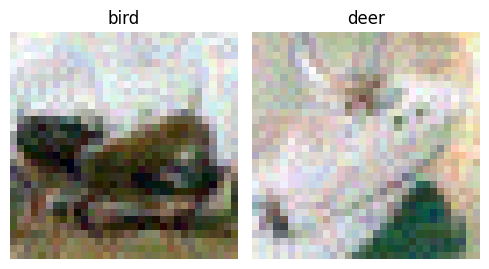

In [30]:
# Define the class names for CIFAR
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))

for i, ax in enumerate(axes.flatten()):
    # Access the image and label at the current index
    image = np.transpose(adaptive_image[i], (1, 2, 0))  # Transpose to (height, width, channels)
    label = adaptive_label[i]

    # Plot the image
    ax.imshow(image)
    ax.set_title(class_names[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [31]:
# Compare the execution time 
import time 

time_logit = []
time_pgd = []

for step, (images, labels) in enumerate(test_loader_cifar):
    images = images.to(device)
    labels = labels.to(device)
    
    start_time = time.time()
    adversarial_batch = pgd_logit_attack(images, labels, normal_model)
    end_time = time.time()
    exec_time = end_time - start_time 
    time_logit.append(exec_time)
    
    start_time = time.time()
    pgd_batch = pgd_attack(normal_model, images, labels)
    end_time = time.time()
    exec_time = end_time - start_time 
    time_pgd.append(exec_time)
    
    if step==5:
        break

In [32]:
time_logit

[3.2963831424713135,
 3.149030923843384,
 3.2640137672424316,
 3.2347981929779053,
 3.2279560565948486,
 3.245455741882324]

In [33]:
time_pgd

[0.6326971054077148,
 0.6402721405029297,
 0.6523830890655518,
 0.6365580558776855,
 0.641568660736084,
 0.6901259422302246]

In [37]:
t1= sum(time_pgd)/(10*6)
t1

0.06489341656366984

In [38]:
t1= sum(time_logit)/(10*6)
t1

0.32362729708353677